## Problem 1 a) - d): 
Implement decision tree from scratch. 

In [2]:
MINIMUM_ENTROPY = 0.01
MINIMUM_PURITY = 1e-15
MAXIMUM_DEPTH = 50

import numpy as np
from numpy import log2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import sys

# Task 1a)
def entropy(y: np.array):
    counts = np.bincount(y)
    p_0 = counts[0] / len(y)
    p_1 = 1 - p_0
    log2p0 = 0 if p_0 == 0 else log2(p_0)  # To accommodate for not taking log of the number 0
    log2p1 = 0 if p_1 == 0 else log2(p_1)
    return -p_0 * log2p0 - p_1 * log2p1

# Task 1b)
def split_feature(x: np.array, y: np.array):
    min_impurity_index = None
    min_impurity = sys.float_info.max
    # Iterate over all values in the features in x. Sort x according to the values
    i_sorted = np.argsort(x)  
    x = x[i_sorted]
    y = y[i_sorted]

    for i in range(len(x)-1):
        sub_1 = y[:i+1]
        sub_2 = y[i+1:]
        e_1 = entropy(sub_1)
        e_2 = entropy(sub_2)
        impurity = e_1 * len(sub_1) / len(x) + e_2 * len(sub_2) / len(x)
        if impurity < min_impurity:
            min_impurity = impurity
            min_impurity_index = i

    split_value = (x[min_impurity_index+1] + x[min_impurity_index])/2  # This is just a type of "regularization" that seem to more stable tree sorting
    return split_value, min_impurity

# Task 1c)
def find_best_split(X: np.array, y: np.array):
    M = X.shape[1]
    min_impurity_global = sys.float_info.max
    min_impurity_feature_index = None
    split_value = None
    for i in range(M):
        feature = X[:, i]
        value, min_impurity = split_feature(feature, y)
        if min_impurity < min_impurity_global:
            min_impurity_global = min_impurity
            min_impurity_feature_index = i
            split_value = value
            # We break out if we find 0 impurity
            if min_impurity_global < MINIMUM_PURITY:
                break

    return min_impurity_feature_index, split_value, min_impurity_global

# Task 1d)
class Tree:
    # Initialize variables
    def __init__(self, level, left):
        self.__split_value = None
        self.__feature_index = None
        self.__left_child = None
        self.__right_child = None
        self.__value = None
        self.__level = level + 1
        if left is None:
            self.__direction = "Root"
        else:
            self.__direction = "Left" if left else "Right"

    # Implements the "GenerateTree"-function from Fig. 9.3 in the book.
    def fit(self, data, labels):

        self.__value = 1 if np.mean(labels) > 0.5 else 0
        if entropy(labels) < MINIMUM_ENTROPY:  # Stopping condition for recursion
            # Pick the label that has the majority. To be used if we are a leaf-node
            print(self.__direction,"leaf node at level",self.__level, "with value", self.__value)
            return

        if self.__level >= MAXIMUM_DEPTH:
            print("Max depth reached, bailing out")
            return

        feature_index, split_value, purity = find_best_split(data, labels)
        #        if purity < MINIMUM_PURITY:
        #            print("0 or close to 0 in impurity, this should be a leaf!")
        #            return

        self.__feature_index = feature_index
        self.__split_value = split_value
        print(self.__direction,"node at level", self.__level, ". Feature index:", feature_index, ", split value",split_value)

        feature = data[:, feature_index]
        indexes_left = np.where(feature <= split_value)[0]
        indexes_right = np.where(feature > split_value)[0]
        if len(indexes_right) == 0 or len(indexes_right) == 0 :
            print("Not able to split data, we consider this a leaf node")
            return

        # Create branches
        self.__left_child = Tree(self.__level, True)
        self.__right_child = Tree(self.__level, False)
        # Generate sub-trees.
        self.__left_child.fit(data[indexes_left, :], labels[indexes_left])
        self.__right_child.fit(data[indexes_right, :], labels[indexes_right])

    # Find leaf corresponding to row
    def __predict(self, x):
        if self.__left_child is None and self.__right_child is None:  # We are a leaf-node
            return self.__value

        feature_val = x[self.__feature_index]
        if feature_val <= self.__split_value:
            return self.__left_child.__predict(x)
        else:
            return self.__right_child.__predict(x)

    def predict(self, X):
        N = X.shape[0]
        y = np.empty(N)
        for i in range(N):
            y[i] = self.__predict(X[i, :])
        return y

# 1f)
data = pd.read_csv("data/tictac-end.csv", skiprows=7, delimiter=" ")
y = data.iloc[:, 0].to_numpy()
X = data.iloc[:, 1:].to_numpy()

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

# 1g)
decision_tree = Tree(0,None)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Precision score
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

Training set shape: (765, 9)
Test set shape: (192, 9)
Root node at level 1 . Feature index: 4 , split value -1.0
Left node at level 2 . Feature index: 0 , split value 1.0
Not able to split data, we consider this a leaf node
Right node at level 2 . Feature index: 6 , split value -1.0
Left node at level 3 . Feature index: 0 , split value -1.0
Left node at level 4 . Feature index: 3 , split value -0.5
Left leaf node at level 5 with value 0
Right node at level 5 . Feature index: 0 , split value -1.0
Not able to split data, we consider this a leaf node
Right node at level 4 . Feature index: 8 , split value -1.0
Left node at level 5 . Feature index: 7 , split value -0.5
Left leaf node at level 6 with value 0
Right node at level 6 . Feature index: 3 , split value 1.0
Not able to split data, we consider this a leaf node
Right leaf node at level 5 with value 1
Right node at level 3 . Feature index: 2 , split value -1.0
Left node at level 4 . Feature index: 0 , split value -1.0
Left node at leve

## Problem 1e) Test the tree with blobs.csv and flame.csv


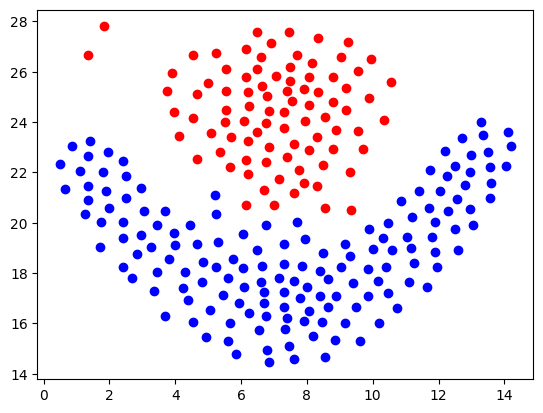

In [3]:
y_and_X = np.genfromtxt("data/flame.csv", delimiter=' ', skip_header=5)
X = y_and_X[:, 1:]

y = y_and_X[:, 0]
X_0 = X[y==0,:]
X_1 = X[y==1,:]

# Ground truth
plt.scatter(X_0[:,0], X_0[:,1], color="red")
plt.scatter(X_1[:,0], X_1[:,1], color="blue")


The task do not mention anything about test/train splitting on this set, so I guess we can just train and test on the same set? Oh well, don't think so, will get perfect results (as shown below) ;-)

Root node at level 1 . Feature index: 1 , split value 20.475
Left leaf node at level 2 with value 1
Right node at level 2 . Feature index: 0 , split value 10.7
Left node at level 3 . Feature index: 0 , split value 3.35
Left node at level 4 . Feature index: 1 , split value 24.95
Left leaf node at level 5 with value 1
Right leaf node at level 5 with value 0
Right node at level 4 . Feature index: 1 , split value 21.15
Left node at level 5 . Feature index: 0 , split value 5.675000000000001
Left leaf node at level 6 with value 1
Right leaf node at level 6 with value 0
Right leaf node at level 5 with value 0
Right leaf node at level 3 with value 1


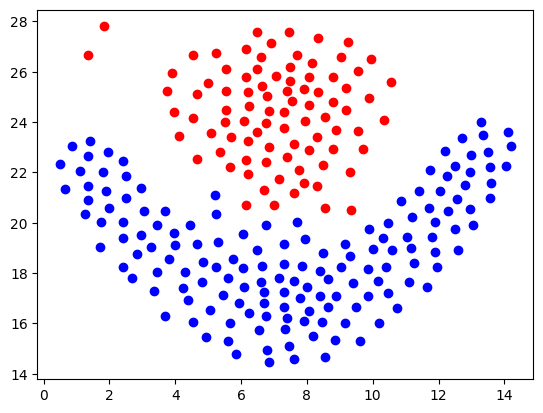

In [4]:
decision_tree = Tree(0,None)
y = y.astype(int)
decision_tree.fit(X, y)

y_pred = decision_tree.predict(X)
X_0 = X[y_pred==0,:]
X_1 = X[y_pred==1,:]
plt.scatter(X_0[:,0], X_0[:,1], color="red")
plt.scatter(X_1[:,0], X_1[:,1], color="blue")



